In [1]:
%reload_ext autoreload
%autoreload 2

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 2. Build a transformer based value agent!!!
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------

In [5]:
# TO DO:
# - then maybe see how a straight up transformer agent does? (No pointer pre-training)
# - also, see if there's an explanation for why the big spikes in loss happen.
# - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the pointerDemonstration code

In [ ]:
# Immediate to-do
# 1. Convert pointer hand sequencing code to an experiment
#    - Start with just output of a sequence given the best possible line and a random "available"
#    - Might be interesting to do a bit of analysis to see what prevents the loss from reaching zero.
# 2. Then use a separate value network to force the encoding to learn how to predict the value of the pointer output.
# 3. Switch the model to be in a reinforcement learning framework
# 4. Switch it to generate an output based on a randomized turn schedule (e.g. possibly be cutoff from generating output and accruing value)
# 5. Predict this with a value function too. 

setting replay to false for tformer agent and not setting any of the replay variables in special init


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


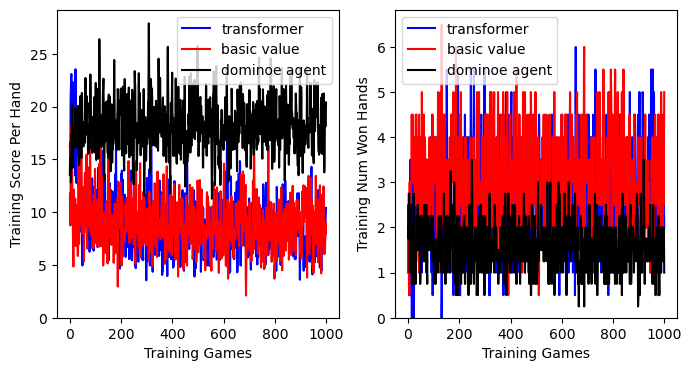

Test winner count:  [18. 32.  0.  0.]
Average score in testing: [ 8.9  7.6 18.2 19.2]


In [22]:
from scipy.signal import savgol_filter

numPlayers = 4
highestDominoe = 9
shuffleAgents = True
defaultAgent = da.dominoeAgent
trainGames = 1000
numRounds = 10
testGames = 50

agents=(da.transformerAgent, da.basicValueAgent, None, None)
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, shuffleAgents=shuffleAgents, agents=agents, defaultAgent=defaultAgent, device=device)
game.getAgent(0).setLearning(True)
game.getAgent(0).setReplay(False)
game.getAgent(1).setLearning(True)
game.getAgent(1).setReplay(False)

# run training rounds
trainWinnerCount = np.zeros(numPlayers)
trainHandWinnerCount = np.zeros((trainGames,numPlayers))
trainScoreTally = np.zeros((trainGames,numPlayers))
for gameIdx in tqdm(range(trainGames)):
    game.playGame(rounds=numRounds)
    trainWinnerCount[game.currentWinner] += 1
    trainHandWinnerCount[gameIdx] += np.sum(game.score==0,axis=0)
    trainScoreTally[gameIdx] += game.currentScore

# run testing rounds
with torch.no_grad():
    game.getAgent(0).setLearning(False)
    game.getAgent(1).setLearning(False)
    testWinnerCount = np.zeros(numPlayers)
    testHandWinnerCount = np.zeros((testGames,numPlayers))
    testScoreTally = np.zeros((testGames,numPlayers))
    for gameIdx in tqdm(range(testGames)):
        game.playGame(rounds=numRounds)
        testWinnerCount[game.currentWinner] += 1
        testHandWinnerCount[gameIdx] += np.sum(game.score==0,axis=0)
        testScoreTally[gameIdx] += game.currentScore

filter = lambda x : savgol_filter(x, 2, 1)


fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(trainGames), 
           filter(trainScoreTally[:,0]/numRounds), 
           c='b', label="transformer")
ax[0].plot(range(trainGames), 
           filter(trainScoreTally[:,1]/numRounds), 
           c='r', label="basic value")
ax[0].plot(range(trainGames), 
           filter(np.mean(trainScoreTally[:,2:],axis=1)/numRounds),
           c='k', label="dominoe agent")
ax[0].set_ylim(0)
ax[0].set_xlabel('Training Games')
ax[0].set_ylabel('Training Score Per Hand')
ax[0].legend(loc='best')

ax[1].plot(range(trainGames), 
           filter(trainHandWinnerCount[:,0]), 
           c='b', label="transformer")
ax[1].plot(range(trainGames), 
           filter(trainHandWinnerCount[:,1]), 
           c='r', label="basic value")
ax[1].plot(range(trainGames), 
           filter(np.mean(trainHandWinnerCount[:,2:],axis=1)), 
           c='k', label="dominoe agent")
ax[1].set_ylim(0)
ax[1].set_xlabel('Training Games')
ax[1].set_ylabel('Training Num Won Hands')
ax[1].legend(loc='best')

plt.show()

# Print results of experiment
print("Test winner count: ", testWinnerCount)
avgScore = np.round(np.mean(testScoreTally/numRounds,axis=0),1)
print(f"Average score in testing: {avgScore}")


In [450]:
# Simple policy for learning the REINFORCE algorithm
from torch import nn        

def randomDominoeHand(numInHand, listDominoes, highestDominoe, batch_size=1, null_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])
    #selection = np.random.choice(numDominoes, (batch_size, numInHand), replace=False)
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, null_token=null_token, with_batch=False) for sel in selection])

    return input, selection


def measureReward(scores, choices, dominoeValues=None, normalize=True, value_offset=1.):
    assert (dominoeValues is not None) and dominoeValues.ndim==3, "dominoeValues must be a (batch_size, num_non_null_options, 2) array"
    assert scores.ndim==3, "scores must have shape (batch_size, num_outputs, num_tokens)"
    batch_size, num_outputs, num_tokens = scores.shape
    device = transformers.get_device(scores)
    assert choices.size(0)==batch_size and choices.size(1)==num_outputs, "choices must have same batch_size and num_outputs as scores"
    dominoeValues = torch.tensor(dominoeValues, dtype=torch.float) # make torch tensor...
    assert dominoeValues.size(0)==batch_size and dominoeValues.size(1)==(num_tokens-1), "dominoeValues must have same batch_size as scores and one less token than scores (because there's a null option)"
    states = torch.zeros((batch_size, num_tokens), dtype=torch.bool).to(device)
    rewards = torch.zeros((batch_size, num_outputs, num_tokens), dtype=torch.float).to(device)
    update_state_src = torch.ones((batch_size,1), dtype=torch.bool).to(device)
    
    tokenValues = torch.sum(dominoeValues,dim=2).to(device)+value_offset # value of each dominoe (e.g. token)
    
    for idx in range(num_outputs):
        # if null hasn't been chosen, assign dominoeValue to each choice if it hasn't been chosen
        rewards[:, idx, :-1] += tokenValues * ~states[:, :-1] # add token value to rewards if it hasn't been chosen yet
        rewards[:, idx, :-1] -= tokenValues * states[:, :-1] # subtract token value to rewards if it has already been chosen
        
        # value of null_token depends on whether all other tokens have been chosen already
        idx_all_chosen = torch.all(states[:,:-1],dim=1) # index of batches where all dominoes except the null_token have been chosen
        
        valueNotChosen = torch.sum(tokenValues * ~states[:, :-1], dim=1) 
        rewards[~idx_all_chosen, idx, -1] = -valueNotChosen[~idx_all_chosen] # reward of null token is negative sum of dominoe not yet chosen
        rewards[idx_all_chosen, idx, -1] = torch.sum(tokenValues[idx_all_chosen], dim=1) # reward of null token is sum of all dominoes if they've all been chosen
        
        # if null has been chosen, then all rewards are the total value of not chosen dominoes
        rewards[states[:,-1], idx] = -valueNotChosen[states[:,-1]].unsqueeze(1) 
        
        # update state array and still_choosing array
        states.scatter_(1, choices[:,idx].unsqueeze(1), update_state_src)
    
    # if requested normalize rewards to total token value 
    if normalize:
        rewards /= torch.sum(tokenValues,1).view(-1,1,1)
    
    return rewards, states


# --------------- the code to run the problem ----------------------
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 100
numInHand = 4
null_token = True

input_dim = 2*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 48
heads = 4
expansion = 1
kqnorm = False
encoding_layers = 1
bias = False
decode_with_gru = False
greedy = True
temperature = 5
alpha = 1e-3


net = transformers.PointerNetwork(input_dim, embedding_dim, heads=heads, expansion=expansion, kqnorm=kqnorm, encoding_layers=encoding_layers, 
                                  bias=bias, decode_with_gru=decode_with_gru, greedy=greedy, temperature=temperature)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

max_output = numInHand + (1 if null_token else 0)

off_policy = False

# run round
trainEpochs = 1000
train_reward = torch.zeros((trainEpochs,max_output))
net.train()
for epoch in tqdm(range(trainEpochs)):
    
    optimizer.zero_grad()
    
    # generate input batch
    input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token)
    input = input.to(device)
    
    # generate state engine
    out_scores, out_choices = net(input, max_output=max_output)
    rewards = measureReward(out_scores, out_choices, dominoeValues=dominoes[selection], normalize=True, value_offset=1.)[0]
    chosen_rewards = torch.gather(rewards, 2, out_choices.unsqueeze(2)).squeeze(2)
    G = torch.cumsum(chosen_rewards, dim=1) # cumulative reward

    if off_policy:
        J = -torch.mean(out_scores * rewards)
    else:
        logprob_policy = torch.gather(out_scores, 2, out_choices.unsqueeze(2)).squeeze(2)
        J = -torch.mean(logprob_policy * G)
        
    J.backward()
    
    optimizer.step()
    train_reward[epoch] = torch.mean(G,dim=0)
    

testEpochs = 100
test_reward = torch.zeros((testEpochs, max_output))
net.temperature = 1
net.eval()
with torch.no_grad():
    for epoch in tqdm(range(testEpochs)):
        input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token)
        input = input.to(device)
        
        # generate state engine
        out_scores, out_choices = net(input, max_output=max_output)
        rewards = measureReward(out_scores, out_choices, dominoeValues=dominoes[selection], normalize=True, value_offset=1.)[0]
        chosen_rewards = torch.gather(rewards, 2, out_choices.unsqueeze(2)).squeeze(2)
        G = torch.cumsum(chosen_rewards, dim=1) # cumulative reward
        test_reward[epoch] = torch.mean(G, dim=0)
        


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.20it/s]


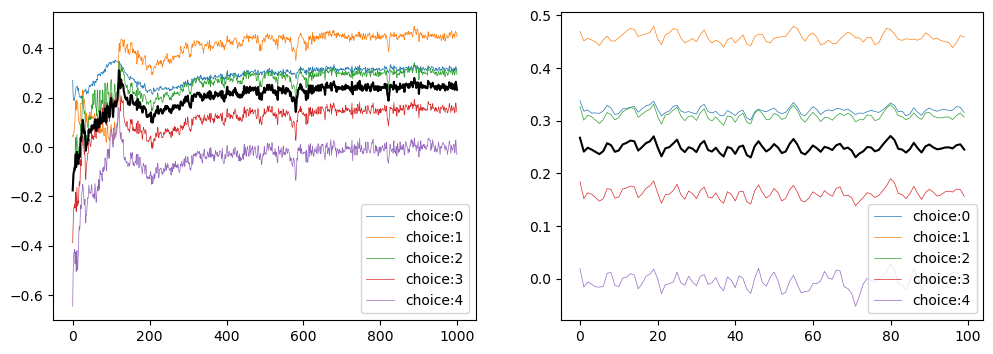

In [451]:
from scipy.signal import savgol_filter
filter = lambda x : savgol_filter(x, 2, 1)

plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(12,4))
for output in range(max_output):
    ax[0].plot(range(trainEpochs), filter(train_reward[:,output]), lw=0.5, label=f"choice:{output}")
    ax[1].plot(range(testEpochs), filter(test_reward[:,output]), lw=0.5, label=f"choice:{output}")

ax[0].plot(range(trainEpochs), filter(torch.mean(train_reward, dim=1)), c='k', lw=1.5)
ax[1].plot(range(testEpochs), filter(torch.mean(test_reward, dim=1)), c='k', lw=1.5)
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')

plt.show()

In [459]:
# --------------- the code to run the problem ----------------------
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 100
numInHand = 8
null_token = True

input_dim = 2*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 48
heads = 4
expansion = 1
kqnorm = False
encoding_layers = 1
bias = False
decode_with_gru = False
greedy = True
temperature = 5
alpha = 1e-3


net = transformers.PointerNetwork(input_dim, embedding_dim, heads=heads, expansion=expansion, kqnorm=kqnorm, encoding_layers=encoding_layers, 
                                  bias=bias, decode_with_gru=decode_with_gru, greedy=greedy, temperature=temperature)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
max_output = numInHand + (1 if null_token else 0)


# # run round
# trainEpochs = 1000
# train_reward = torch.zeros((trainEpochs,max_output))
# net.train()
# for epoch in tqdm(range(trainEpochs)):
    
#     optimizer.zero_grad()
    
#     # generate input batch
#     input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token)
#     input = input.to(device)
    
#     # generate state engine
#     out_scores, out_choices = net(input)

batch_size = 1
input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token)

print(dominoes[selection])

[[[7 7]
  [1 6]
  [1 1]
  [9 9]
  [2 9]
  [6 8]
  [4 4]
  [1 3]]]


100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [19:23:55<00:00,  1.75s/it]


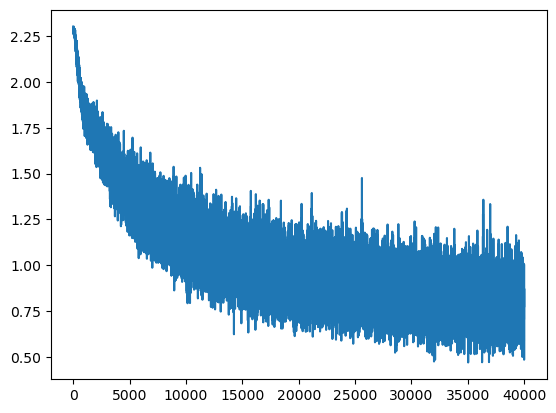

In [645]:
def randomDominoeHand(numInHand, listDominoes, highestDominoe, batch_size=1, null_token=True, available_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])
    if available_token:
        available = np.random.randint(0, highestDominoe+1, batch_size)
    else:
        available = [None]*batch_size
    
    # create tensor representations
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, available=ava,
                                          available_token=available_token, null_token=null_token, with_batch=False) 
                         for sel,ava in zip(selection, available)])
    return input, selection, available
    
def getBestLine(dominoes, selection, highestDominoe):
    bestSequence = []
    bestDirection = []
    for sel in selection:
        cBestSeq = []
        cBestDir = []
        cBestVal = []
        for available in range(highestDominoe+1):
            cseq, cdir = df.constructLineRecursive(dominoes, sel, available)
            cval = [np.sum(dominoes[cs]) for cs in cseq]
            cidx = max(enumerate(cval), key=lambda x: x[1])[0]
            cBestSeq.append(cseq[cidx])
            cBestDir.append(cdir[cidx])
            cBestVal.append(cval[cidx])

        cBestIdx = max(enumerate(cBestVal), key=lambda x: x[1])[0]
        bestSequence.append(cBestSeq[cBestIdx])
        bestDirection.append(cBestDir[cBestIdx])

    return bestSequence, bestDirection

def getBestLineFromAvailable(dominoes, selection, highestDominoe, available):
    bestSequence = []
    bestDirection = []
    for sel, ava in zip(selection, available):
        cseq, cdir = df.constructLineRecursive(dominoes, sel, ava)
        cval = [np.sum(dominoes[cs]) for cs in cseq]
        cidx = max(enumerate(cval), key=lambda x: x[1])[0]
        bestSequence.append(cseq[cidx])
        bestDirection.append(cdir[cidx])
    return bestSequence, bestDirection
    
def convertToHandIndex(selection, bestSequence):
    indices = []
    for sel,seq in zip(selection, bestSequence):
        # look up table for current selection
        elementIdx = {element:idx for idx, element in enumerate(sel)}
        indices.append([elementIdx[element] for element in seq])
    return indices
    
def padBestLine(bestSequence, max_output, ignore_index=-1):
    for bs in bestSequence:
        bs += [ignore_index]*(max_output-len(bs))
    return bestSequence

def generateBatch(highestDominoe, dominoes, batch_size, numInHand, available_token=False, null_token=False, ignore_index=-1, return_full=False):
    input, selection, available = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token, available_token=available_token)
    if available_token:
        bestSequence, bestDirection = getBestLineFromAvailable(dominoes, selection, highestDominoe, available)
    else:
        bestSequence, bestDirection = getBestLine(dominoes, selection, highestDominoe)
    iseq = convertToHandIndex(selection, bestSequence)
    target = torch.tensor(np.stack(padBestLine(iseq, numInHand+(1 if null_token else 0), ignore_index=ignore_index)), dtype=torch.long)
    if return_full:
        return input, target, bestSequence, bestDirection, selection, available
    return input, target
    

# input parameters
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 48
numInHand = 10
null_token = False
available_token = False
num_output = numInHand + (1 if null_token else 0)
ignore_index = -1

# network parameters
input_dim = (2 if not(available_token) else 3)*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 96
heads = 8
expansion = 1
kqnorm = False
encoding_layers = 2
bias = False
decode_with_gru = False
greedy = False
temperature = 2
alpha = 1e-3

# create network and optimizer
net = transformers.PointerNetwork(input_dim, embedding_dim, heads=heads, expansion=expansion, kqnorm=kqnorm, encoding_layers=encoding_layers, 
                                  bias=bias, decode_with_gru=decode_with_gru, greedy=greedy, temperature=temperature)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=alpha)

# do training
net.train()
trainEpochs = 40000
trainLoss = torch.zeros(trainEpochs)
for epoch in tqdm(range(trainEpochs)):
    # zero gradients
    optimizer.zero_grad()

    # generate input batch
    input, target = generateBatch(highestDominoe, dominoes, batch_size, numInHand, available_token=available_token, ignore_index=ignore_index)
    input, target = input.to(device), target.to(device)

    # propagate it through the network
    out_scores, out_choices = net(input)

    # measure loss and do backward pass
    unrolled = out_scores.view(batch_size * num_output, -1)
    loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=ignore_index)
    loss.backward()

    # update network
    optimizer.step()

    trainLoss[epoch] = loss.item()
    
plt.close('all')
plt.plot(range(trainEpochs), trainLoss)
plt.show()

In [611]:
batch_size = 1

input, target, sequence, direction, selection = generateBatch(highestDominoe, dominoes, batch_size, numInHand, ignore_index=ignore_index, return_full=True)
input, target = input.to(device), target.to(device)

# propagate it through the network
out_scores, out_choices = net(input)

In [635]:
def randomDominoeHand(numInHand, listDominoes, highestDominoe, available=None, batch_size=1, null_token=True, available_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])

    # create tensor representations
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, available=available,
                                          available_token=available_token, null_token=null_token, with_batch=False) for sel in selection])
    return input, selection

input, selection = randomDominoeHand(3, df.listDominoes(4), 4, available=1)
print(selection)


11
[[ 0 10  7]]


In [636]:
input.shape

torch.Size([1, 5, 16])

In [637]:
input[0]

tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [638]:
selection

array([[ 0, 10,  7]])

In [639]:
df.listDominoes(4)[selection]

array([[[0, 0],
        [2, 3],
        [1, 3]]])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.96it/s]


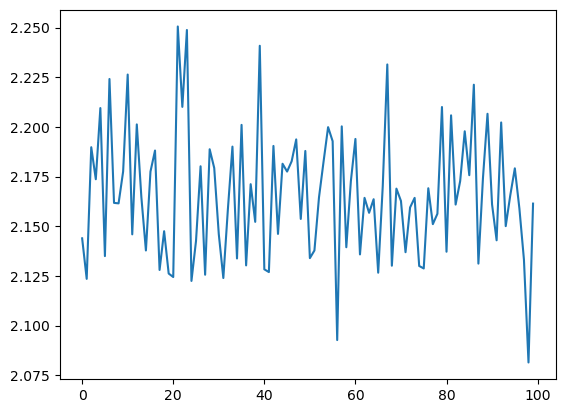

In [589]:
testEpochs = 100
testLoss = torch.zeros(testEpochs)
with torch.no_grad():
    net.eval()

    for epoch in tqdm(range(testEpochs)):
        input, target = generateBatch(highestDominoe, dominoes, batch_size, numInHand, ignore_index=ignore_index)
        input, target = input.to(device), target.to(device)
    
        # propagate it through the network
        out_scores, out_choices = net(input)
    
        # measure loss
        unrolled = out_scores.view(batch_size * num_output, -1)
        loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=ignore_index)
        testLoss[epoch] = loss.item()
        
plt.close('all')
plt.plot(range(testEpochs), testLoss)
plt.show()

## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [217]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, da.dominoeAgent, da.bestLineAgent))
game.playGame()
game.printResults()

[[ 5  0 13  7]
 [ 5 11  0  6]
 [ 6  0 49 18]
 [ 7 39 29  0]
 [11 33 20  0]
 [ 6  2 26  0]
 [19 23 17  0]
 [ 0  3 24  7]
 [23 19  0  6]
 [ 7 24 40  0]]
[ 89 154 218  44]
The current winner is agent: 3 with a score of 44!


In [213]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|8 ', ' 8|4 ', ' 4|5 ', ' 5|9 ', ' 9|9 ', ' 9|4 ', ' 4|6 ', ' 6|5 ', ' 5|3 ', ' 3|4 ', ' 4|2 ']
player 1:  [' 0|5 ', ' 5|7 ', ' 7|3 ', ' 3|3 ', ' 3|6 ', ' 6|0 ', ' 0|3 ', ' 3|2 ']
player 2:  [' 0|9 ', ' 9|8 ', ' 8|3 ', ' 3|9 ', ' 9|7 ', ' 7|2 ', ' 2|5 ', ' 5|1 ', ' 1|0 ', ' 0|2 ', ' 2|8 ']
player 3:  [' 0|7 ', ' 7|7 ', ' 7|8 ', ' 8|8 ', ' 8|5 ', ' 5|5 ']
dummy:  [' 0|4 ', ' 4|4 ', ' 4|7 ', ' 7|6 ', ' 6|9 ', ' 9|2 ', ' 2|1 ', ' 1|1 ', ' 1|8 ', ' 8|6 ', ' 6|1 ', ' 1|9 ']


In [195]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|8 ', ' 8|5 ', ' 5|5 ']
[' 9|3 ', ' 3|3 ', ' 3|5 ', ' 5|7 ']
[' 9|8 ', ' 8|0 ', ' 0|1 ', ' 1|7 ', ' 7|4 ', ' 4|6 ', ' 6|9 ', ' 9|1 ', ' 1|5 ', ' 5|4 ', ' 4|2 ', ' 2|7 ', ' 7|6 ', ' 6|8 ']
[' 9|5 ', ' 5|6 ', ' 6|6 ', ' 6|0 ', ' 0|0 ', ' 0|9 ', ' 9|4 ', ' 4|8 ', ' 8|1 ']
[' 9|2 ', ' 2|2 ', ' 2|0 ', ' 0|5 ', ' 5|2 ', ' 2|3 ', ' 3|8 ', ' 8|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|0 ', ' 0|3 ', ' 3|7 ', ' 7|7 ', ' 7|0 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


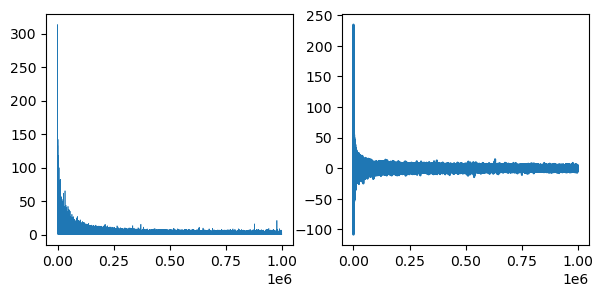

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()

In [206]:
print("hello")

hello
